# 🚗 UFLD Fine-Tuning on CARLA Dataset

**Goal:** Fine-tune Ultra-Fast-Lane-Detection (TuSimple) model on CARLA synthetic data.

| Component | Description |
|-----------|-------------|
| **Model** | ResNet18 backbone, 100 grid cells, 56 row anchors |
| **Loss** | SoftmaxFocalLoss + ParsingRelationLoss + ParsingRelationDis |
| **Input** | 800×288 RGB images |

In [10]:
# ============================================================================
# CELL 1: Imports & Setup
# ============================================================================

#%pip install opencv-python tqdm matplotlib gdown --quiet

import os, json
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Clone UFLD if needed
#if not os.path.exists('ultrafastLaneDetector'):
 #   !git clone --depth 1 https://github.com/ibaiGorordo/pytorch-Ultra-Fast-Lane-Detection-Inference.git ufld_temp
  #  !mv ufld_temp/ultrafastLaneDetector ./ultrafastLaneDetector && rm -rf ufld_temp

from ultrafastLaneDetector.model import parsingNet
print(f"✅ PyTorch {torch.__version__} | CUDA: {torch.cuda.is_available()}")

✅ PyTorch 2.4.1+cu121 | CUDA: True


In [11]:
# ============================================================================
# CELL 2: Download Pretrained Model & Check GPU
# ============================================================================

if not os.path.exists('tusimple_18.pth'):
    import gdown
    gdown.download('https://drive.google.com/uc?id=1WCYyur5ZaWczH15ecmeDowrW30xcLrCn', 'tusimple_18.pth', quiet=False)
print(f"✅ tusimple_18.pth: {'exists' if os.path.exists('tusimple_18.pth') else 'MISSING'}")

if torch.cuda.is_available():
    print(f"🖥️  GPU: {torch.cuda.get_device_name(0)} ({torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB)")
else:
    print("⚠️  No GPU - using CPU")

✅ tusimple_18.pth: exists
🖥️  GPU: NVIDIA GeForce RTX 4060 Laptop GPU (8.2 GB)


In [12]:
# ============================================================================
# CELL 3: Loss Functions (UFLD-specific)
# ============================================================================

class SoftmaxFocalLoss(nn.Module):
    """Focal loss for row-anchor classification - focuses on hard examples."""
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.nll = nn.NLLLoss()
    
    def forward(self, logits, labels):
        scores = F.softmax(logits, dim=1)
        factor = torch.pow(1.0 - scores, self.gamma)
        log_score = F.log_softmax(logits, dim=1)
        return self.nll(factor * log_score, labels)


class ParsingRelationLoss(nn.Module):
    """Structural consistency - penalizes large position differences between row anchors."""
    def __init__(self):
        super().__init__()
    
    def forward(self, logits):
        n, c, h, w = logits.shape
        loss_all = []
        for i in range(w):
            pred = logits[:, :c-1, :, i]
            prob = F.softmax(pred, dim=1)
            idx = torch.arange(c-1, device=logits.device, dtype=torch.float32).view(1, -1, 1)
            loc = torch.sum(prob * idx, dim=1)
            loc_diff = loc[:, :-1] - loc[:, 1:]
            loss_all.append(torch.mean(loc_diff ** 2))
        return sum(loss_all) / len(loss_all)


class ParsingRelationDis(nn.Module):
    """Shape consistency - penalizes second-order differences (curvature changes)."""
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
    
    def forward(self, logits):
        n, dim, num_rows, num_lanes = logits.shape
        logits = logits[:, :dim-1, :, :]
        prob = F.softmax(logits, dim=1)
        idx = torch.arange(dim-1, device=logits.device, dtype=torch.float32).view(1, -1, 1, 1)
        loc = torch.sum(prob * idx, dim=1)
        loc_diff = loc[:, :-1, :] - loc[:, 1:, :]
        loc_diff_diff = loc_diff[:, :-1, :] - loc_diff[:, 1:, :]
        return self.l1(loc_diff_diff, torch.zeros_like(loc_diff_diff))

print("✅ Loss functions: SoftmaxFocalLoss, ParsingRelationLoss, ParsingRelationDis")

✅ Loss functions: SoftmaxFocalLoss, ParsingRelationLoss, ParsingRelationDis


In [13]:
# ============================================================================
# CELL 4: Dataset Class
# ============================================================================

class CARLALaneDataset(Dataset):
    """
    Converts CARLA segmentation masks to UFLD row-anchor grid labels.
    - Row anchors: fixed y positions sampled from bottom 60% of image
    - Grid labels: x position quantized into griding_num bins per row
    """
    
    def __init__(self, dataset_root, list_file, img_size=(288, 800),
                 griding_num=100, cls_num_per_lane=56, num_lanes=4, transform=None):
        self.dataset_root = Path(dataset_root)
        self.img_size = img_size
        self.griding_num = griding_num
        self.cls_num_per_lane = cls_num_per_lane
        self.num_lanes = num_lanes
        self.transform = transform
        self.row_anchor = self._compute_row_anchors()
        
        # Parse list file
        self.samples = []
        with open(list_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:
                    self.samples.append({
                        'image': parts[0].lstrip('/'),
                        'label': parts[1].lstrip('/'),
                        'lane_exists': [int(x) for x in parts[2:6]]
                    })
        print(f"Loaded {len(self.samples)} samples | size={img_size} | grid={griding_num} | rows={cls_num_per_lane}")
    
    def _compute_row_anchors(self):
        H = self.img_size[0]
        return np.linspace(int(H * 0.4), H - 1, self.cls_num_per_lane).astype(int)
    
    def _seg_to_grid(self, label):
        H, W = label.shape
        grid = np.ones((self.num_lanes, self.cls_num_per_lane), dtype=np.int64) * self.griding_num
        for row_idx, y in enumerate(self.row_anchor):
            if y >= H: continue
            row = label[y, :]
            for seg_val, lane_idx in {1: 0, 2: 1}.items():  # 1=left, 2=right
                pixels = np.where(row == seg_val)[0]
                if len(pixels) > 0:
                    x = int(np.mean(pixels) / W * self.griding_num)
                    grid[lane_idx, row_idx] = min(max(x, 0), self.griding_num - 1)
        return grid
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load & resize
        img = cv2.cvtColor(cv2.imread(str(self.dataset_root / sample['image'])), cv2.COLOR_BGR2RGB)
        label = cv2.imread(str(self.dataset_root / sample['label']), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        label = cv2.resize(label, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_NEAREST)
        
        # Transform
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy((img / 255.0 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]).permute(2, 0, 1).float()
        
        return img, torch.from_numpy(self._seg_to_grid(label)).long(), torch.tensor(sample['lane_exists'], dtype=torch.float32)

print("✅ CARLALaneDataset class ready")

✅ CARLALaneDataset class ready


In [14]:
# ============================================================================
# CELL 5: Trainer Class
# ============================================================================

class UFLDTrainer:
    """Complete UFLD fine-tuning pipeline."""
    
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() and config['use_gpu'] else 'cpu')
        self.output_dir = Path(config['output_dir'])
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.best_val_loss = float('inf')
        self.history = {'train': [], 'val': []}
        
        self._setup_data()
        self._setup_model()
        self._setup_training()
        print(f"✅ Trainer ready | Device: {self.device} | Train: {len(self.train_loader.dataset)} | Val: {len(self.val_loader.dataset)}")
    
    def _setup_data(self):
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        cfg = self.config
        kwargs = dict(img_size=(cfg['img_h'], cfg['img_w']), griding_num=cfg['griding_num'],
                      cls_num_per_lane=cfg['cls_num_per_lane'], num_lanes=4, transform=transform)
        
        self.train_loader = DataLoader(
            CARLALaneDataset(cfg['dataset_root'], f"{cfg['dataset_root']}/list/train_gt.txt", **kwargs),
            batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['num_workers'], pin_memory=True)
        self.val_loader = DataLoader(
            CARLALaneDataset(cfg['dataset_root'], f"{cfg['dataset_root']}/list/val_gt.txt", **kwargs),
            batch_size=cfg['batch_size'], shuffle=False, num_workers=cfg['num_workers'], pin_memory=True)
    
    def _setup_model(self):
        cfg = self.config
        self.model = parsingNet(
            size=(cfg['img_h'], cfg['img_w']), pretrained=False, backbone=cfg['backbone'],
            cls_dim=(cfg['griding_num'] + 1, cfg['cls_num_per_lane'], 4), use_aux=cfg['use_aux']
        )
        if cfg['pretrained_model'] and os.path.exists(cfg['pretrained_model']):
            state = torch.load(cfg['pretrained_model'], map_location='cpu', weights_only=False)
            state = state.get('model', state.get('state_dict', state))
            self.model.load_state_dict(state, strict=True)
            print(f"✅ Loaded pretrained: {cfg['pretrained_model']}")
        self.model = self.model.to(self.device)
    
    def _setup_training(self):
        cfg = self.config
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['weight_decay'])
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=cfg['epochs'], eta_min=cfg['learning_rate']*0.01)
        self.cls_loss = SoftmaxFocalLoss(gamma=2)
        self.sim_loss = ParsingRelationLoss()
        self.shp_loss = ParsingRelationDis()
    
    def _compute_loss(self, out, labels):
        B, G, H, L = out.shape
        cls = self.cls_loss(out.permute(0, 3, 2, 1).reshape(-1, G), labels.reshape(-1))
        sim = self.sim_loss(out)
        shp = self.shp_loss(out)
        total = cls + self.config['sim_weight'] * sim + self.config['shp_weight'] * shp
        return total, {'total': total.item(), 'cls': cls.item(), 'sim': sim.item(), 'shp': shp.item()}
    
    def _run_epoch(self, loader, train=True):
        self.model.train() if train else self.model.eval()
        total, comps = 0, {'cls': 0, 'sim': 0, 'shp': 0}
        ctx = torch.enable_grad() if train else torch.no_grad()
        
        with ctx:
            pbar = tqdm(loader, desc='Train' if train else 'Val', leave=False)
            for imgs, labels, _ in pbar:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                out = self.model(imgs)
                loss, d = self._compute_loss(out, labels)
                
                if train:
                    self.optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config['grad_clip'])
                    self.optimizer.step()
                
                total += d['total']
                for k in comps: comps[k] += d[k]
                pbar.set_postfix(loss=f"{d['total']:.4f}")
        
        n = len(loader)
        return total/n, {k: v/n for k, v in comps.items()}
    
    def train(self):
        print(f"\n{'='*50}\n🚀 Starting Training: {self.config['epochs']} epochs\n{'='*50}")
        for epoch in range(1, self.config['epochs'] + 1):
            train_loss, train_comp = self._run_epoch(self.train_loader, train=True)
            val_loss, val_comp = self._run_epoch(self.val_loader, train=False)
            self.scheduler.step()
            
            self.history['train'].append(train_loss)
            self.history['val'].append(val_loss)
            
            is_best = val_loss < self.best_val_loss
            if is_best: self.best_val_loss = val_loss
            self._save(epoch, val_loss, is_best)
            
            print(f"Epoch {epoch}/{self.config['epochs']}: Train={train_loss:.4f} Val={val_loss:.4f} {'⭐' if is_best else ''}")
        
        self._save_history()
        print(f"\n{'='*50}\n✅ Training Complete! Best Val: {self.best_val_loss:.4f}\n{'='*50}")
    
    def _save(self, epoch, val_loss, is_best):
        ckpt = {'epoch': epoch, 'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(), 'val_loss': val_loss, 'config': self.config}
        torch.save(ckpt, self.output_dir / 'checkpoint_latest.pth')
        if is_best: torch.save(ckpt, self.output_dir / 'checkpoint_best.pth')
    
    def _save_history(self):
        with open(self.output_dir / 'history.json', 'w') as f:
            json.dump(self.history, f)

print("✅ UFLDTrainer class ready")

✅ UFLDTrainer class ready


In [15]:
# ============================================================================
# CELL 6: Configuration
# ============================================================================

# === TEST MODE: True for 2 epochs, False for full training ===
TEST_MODE = False  # <-- SET TO FALSE FOR FULL 50 EPOCH TRAINING

# Auto-detect environment
LOCAL_PATH = './ufld_carla_dataset_v3'
COLAB_PATH = './ufld_carla_dataset'

if os.path.exists(LOCAL_PATH):
    dataset_root, batch_size, num_workers = LOCAL_PATH, 32, 4
    print("🟢 Local environment")
elif os.path.exists(COLAB_PATH):
    dataset_root, batch_size, num_workers = COLAB_PATH, 32, 2
    print("🔵 Colab environment")
else:
    raise FileNotFoundError("Dataset not found! Check paths.")

config = {
    'dataset_root': dataset_root,
    'pretrained_model': 'tusimple_18.pth',
    'output_dir': 'ufld_finetuned_carla',
    
    # Model architecture (TuSimple)
    'backbone': '18', 'griding_num': 100, 'cls_num_per_lane': 56,
    'img_w': 800, 'img_h': 288, 'use_aux': False,
    
    # Training
    'batch_size': batch_size, 'num_workers': num_workers,
    'epochs': 2 if TEST_MODE else 50,
    'learning_rate': 1e-4, 'weight_decay': 1e-4, 'grad_clip': 1.0,
    'sim_weight': 1.0, 'shp_weight': 0.0, 'use_gpu': True,
}

print(f"{'⚠️ TEST MODE (2 epochs)' if TEST_MODE else '🔥 FULL TRAINING (50 epochs)'}")
print(f"Dataset: {config['dataset_root']} | Batch: {config['batch_size']} | Epochs: {config['epochs']}")

🟢 Local environment
🔥 FULL TRAINING (50 epochs)
Dataset: ./ufld_carla_dataset_v3 | Batch: 32 | Epochs: 50


Loaded 7000 samples | size=(288, 800) | grid=100 | rows=56
Loaded 2000 samples | size=(288, 800) | grid=100 | rows=56
🔍 Training Set Samples:


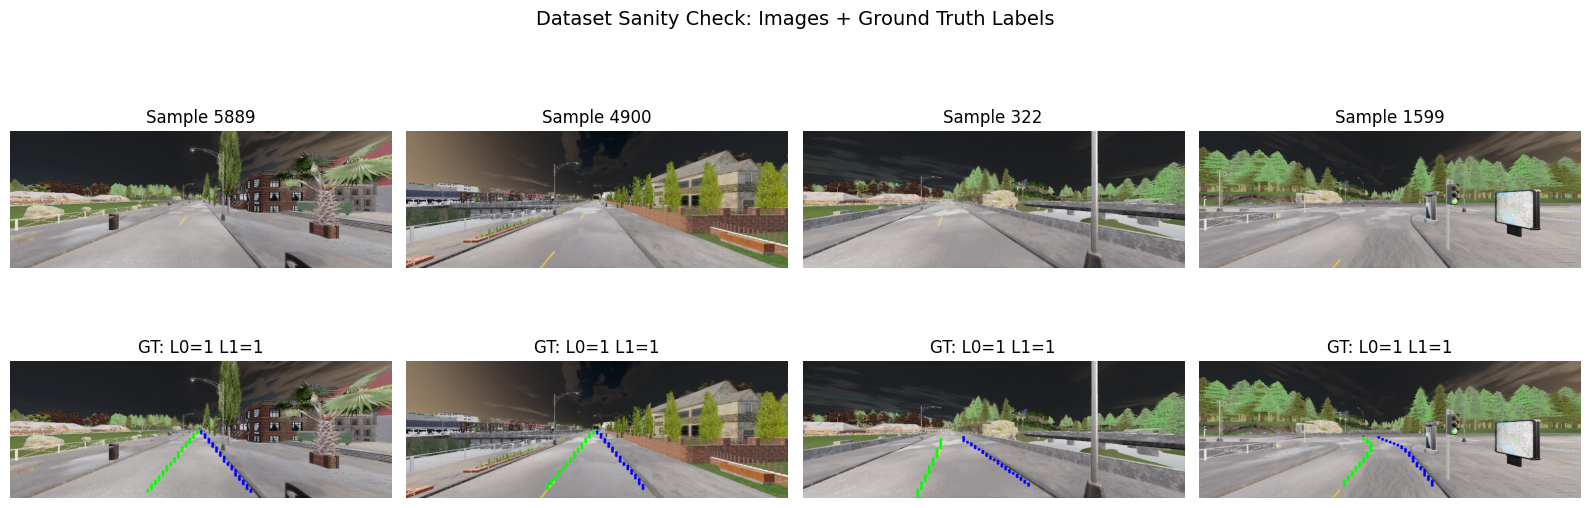


 Dataset Stats:
   Total samples: 7000
   Image shape: torch.Size([3, 288, 800]) (C, H, W)
   Label shape: torch.Size([4, 56]) (num_lanes, row_anchors)
   Grid range: [0, 100] (100=no lane)

🔍 Validation Set Samples:


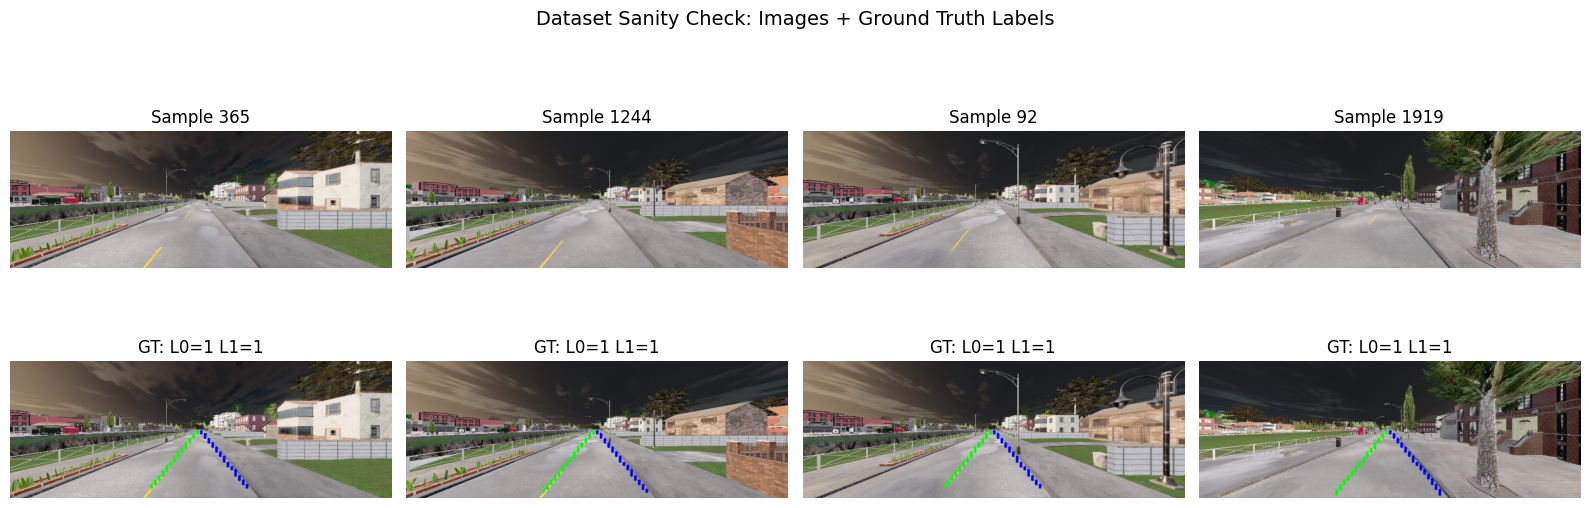


 Dataset Stats:
   Total samples: 2000
   Image shape: torch.Size([3, 288, 800]) (C, H, W)
   Label shape: torch.Size([4, 56]) (num_lanes, row_anchors)
   Grid range: [0, 100] (100=no lane)


In [16]:
# ============================================================================
# CELL 7: Sanity Check - Dataset Samples
# ============================================================================

def show_dataset_samples(dataset, n=4):
    """Display random samples from dataset with ground truth lanes."""
    row_anchors = np.linspace(int(config['img_h']*0.4), config['img_h']-1, config['cls_num_per_lane']).astype(int)
    
    fig, axes = plt.subplots(2, n, figsize=(4*n, 6))
    fig.suptitle('Dataset Sanity Check: Images + Ground Truth Labels', fontsize=14)
    
    for i in range(n):
        idx = np.random.randint(len(dataset))
        img, gt, lane_exists = dataset[idx]
        
        # Denormalize image
        vis = np.clip(img.permute(1,2,0).numpy() * [0.229,0.224,0.225] + [0.485,0.456,0.406], 0, 1)
        
        # Raw image
        axes[0, i].imshow(vis)
        axes[0, i].set_title(f'Sample {idx}')
        axes[0, i].axis('off')
        
        # Image with GT lanes
        img_gt = vis.copy()
        colors = [(0,1,0), (0,0,1), (1,0,1), (1,1,0)]
        for lane in range(4):
            if lane_exists[lane] > 0:
                for row_idx, y in enumerate(row_anchors):
                    x_grid = gt[lane, row_idx].item()
                    if x_grid < config['griding_num']:
                        x = int(x_grid * config['img_w'] / config['griding_num'])
                        cv2.circle(img_gt, (x, y), 3, colors[lane], -1)
        
        axes[1, i].imshow(img_gt)
        axes[1, i].set_title(f'GT: L0={lane_exists[0]:.0f} L1={lane_exists[1]:.0f}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    print(f"\n Dataset Stats:")
    print(f"   Total samples: {len(dataset)}")
    print(f"   Image shape: {img.shape} (C, H, W)")
    print(f"   Label shape: {gt.shape} (num_lanes, row_anchors)")
    print(f"   Grid range: [0, {config['griding_num']}] ({config['griding_num']}=no lane)")

# Create dataset for sanity check
transform = transforms.Compose([
    transforms.ToPILImage(), transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = CARLALaneDataset(
    config['dataset_root'], f"{config['dataset_root']}/list/train_gt.txt",
    img_size=(config['img_h'], config['img_w']), griding_num=config['griding_num'],
    cls_num_per_lane=config['cls_num_per_lane'], num_lanes=4, transform=transform
)
val_dataset = CARLALaneDataset(
    config['dataset_root'], f"{config['dataset_root']}/list/val_gt.txt",
    img_size=(config['img_h'], config['img_w']), griding_num=config['griding_num'],
    cls_num_per_lane=config['cls_num_per_lane'], num_lanes=4, transform=transform
)

print("🔍 Training Set Samples:")
show_dataset_samples(train_dataset)
print("\n🔍 Validation Set Samples:")
show_dataset_samples(val_dataset)

🧪 Testing PRETRAINED TuSimple model (before fine-tuning on CARLA):
✅ Loaded: tusimple_18.pth
✅ Loaded: tusimple_18.pth


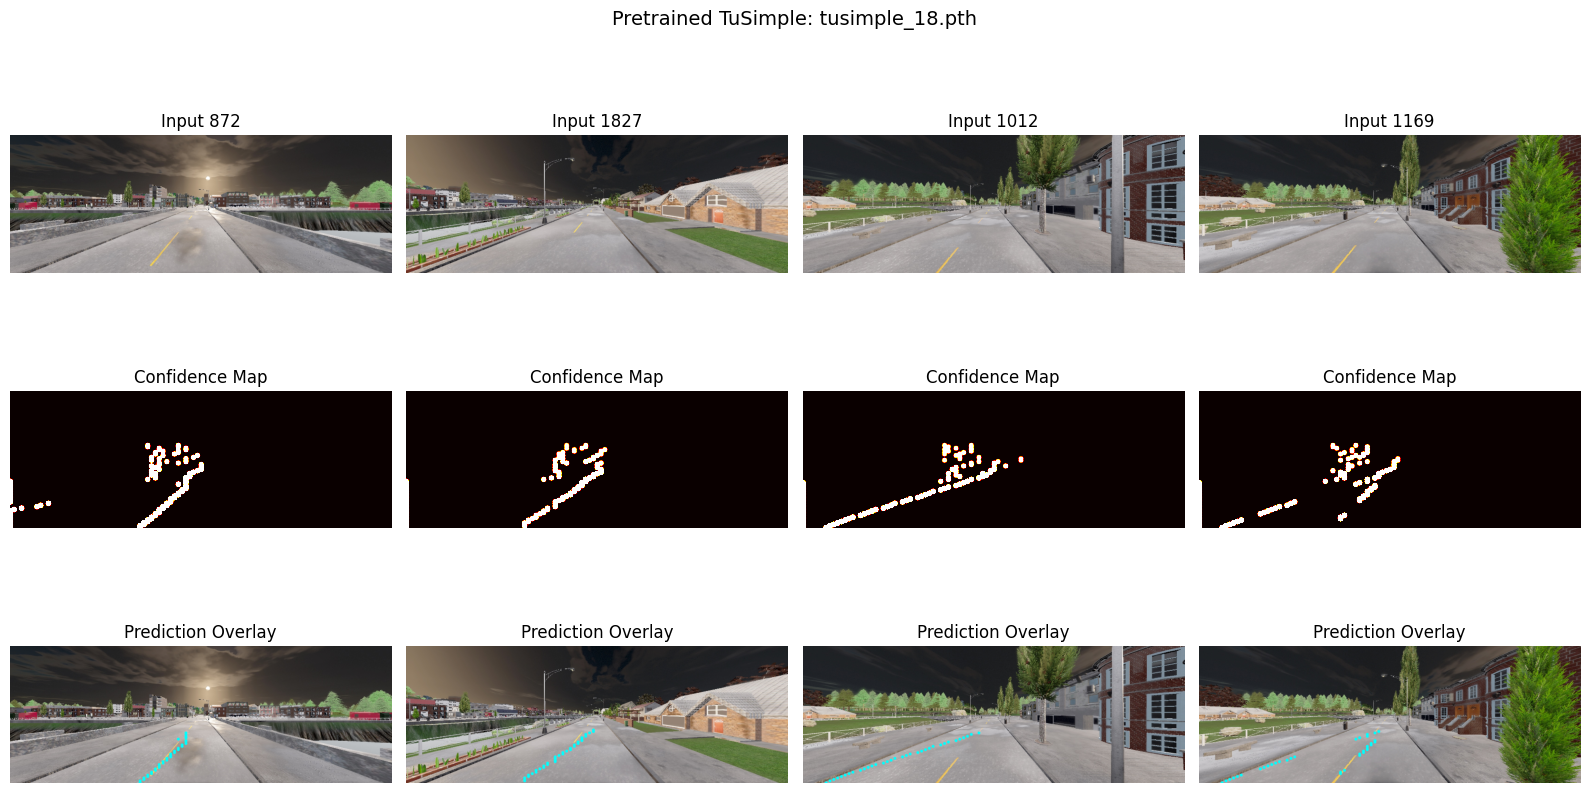

📐 Output Shape: (101, 56, 4) (griding+1, row_anchors, lanes)


In [17]:
# ============================================================================
# CELL 8: Sanity Check - Model Output (Before Training)
# ============================================================================

def test_model_forward(model_path, dataset, n=4, title="Model"):
    """Test model forward pass and visualize raw outputs."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model = parsingNet(size=(config['img_h'], config['img_w']), pretrained=False, backbone=config['backbone'],
                       cls_dim=(config['griding_num']+1, config['cls_num_per_lane'], 4), use_aux=False)
    
    if os.path.exists(model_path):
        ckpt = torch.load(model_path, map_location='cpu', weights_only=False)
        # Handle different checkpoint formats
        if 'model_state_dict' in ckpt:
            state = ckpt['model_state_dict']
        elif 'model' in ckpt:
            state = ckpt['model']
        elif 'state_dict' in ckpt:
            state = ckpt['state_dict']
        else:
            state = ckpt
        model.load_state_dict(state, strict=True)
        print(f"✅ Loaded: {model_path}")
    else:
        print(f"⚠️ No model at {model_path}, using random weights")
    
    model.eval().to(device)
    row_anchors = np.linspace(int(config['img_h']*0.4), config['img_h']-1, config['cls_num_per_lane']).astype(int)
    
    fig, axes = plt.subplots(3, n, figsize=(4*n, 9))
    fig.suptitle(f'{title}: {os.path.basename(model_path)}', fontsize=14)
    
    for i in range(n):
        idx = np.random.randint(len(dataset))
        img, gt, _ = dataset[idx]
        
        # Forward pass
        with torch.no_grad():
            out = model(img.unsqueeze(0).to(device)).squeeze().cpu().numpy()  # (101, 56, 4)
        
        # Denormalize
        vis = np.clip(img.permute(1,2,0).numpy() * [0.229,0.224,0.225] + [0.485,0.456,0.406], 0, 1)
        
        # Row 1: Raw image
        axes[0, i].imshow(vis)
        axes[0, i].set_title(f'Input {idx}')
        axes[0, i].axis('off')
        
        # Row 2: Output heatmap (confidence)
        conf_map = np.zeros((config['img_h'], config['img_w']))
        for lane in range(2):
            for row_idx, y in enumerate(row_anchors):
                probs = out[:config['griding_num'], row_idx, lane]
                x_pred = np.argmax(probs)
                conf = probs[x_pred]
                if conf > 0.1:
                    x = int(x_pred * config['img_w'] / config['griding_num'])
                    cv2.circle(conf_map, (x, y), 5, float(conf), -1)
        
        axes[1, i].imshow(conf_map, cmap='hot', vmin=0, vmax=1)
        axes[1, i].set_title('Confidence Map')
        axes[1, i].axis('off')
        
        # Row 3: Prediction superimposed
        img_pred = vis.copy()
        colors = [(1,0,0), (0,1,1)]
        for lane in range(2):
            for row_idx, y in enumerate(row_anchors):
                probs = out[:, row_idx, lane]
                x_pred = np.argmax(probs)
                if x_pred < config['griding_num'] and probs[x_pred] > 0.3:
                    x = int(x_pred * config['img_w'] / config['griding_num'])
                    cv2.circle(img_pred, (x, y), 3, colors[lane], -1)
        
        axes[2, i].imshow(img_pred)
        axes[2, i].set_title('Prediction Overlay')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"📐 Output Shape: {out.shape} (griding+1, row_anchors, lanes)")

# Test with pretrained model
print("🧪 Testing PRETRAINED TuSimple model (before fine-tuning on CARLA):")
test_model_forward('tusimple_18.pth', val_dataset, title="Pretrained TuSimple")

In [18]:
# ============================================================================
# CELL 7: Train Model
# ============================================================================

trainer = UFLDTrainer(config)
trainer.train()

Loaded 7000 samples | size=(288, 800) | grid=100 | rows=56
Loaded 2000 samples | size=(288, 800) | grid=100 | rows=56
✅ Loaded pretrained: tusimple_18.pth
✅ Trainer ready | Device: cuda | Train: 7000 | Val: 2000

🚀 Starting Training: 50 epochs
✅ Loaded pretrained: tusimple_18.pth
✅ Trainer ready | Device: cuda | Train: 7000 | Val: 2000

🚀 Starting Training: 50 epochs


Epoch 1/50: Train=0.3847 Val=0.1107 ⭐


Epoch 2/50: Train=0.0910 Val=0.0829 ⭐


Epoch 3/50: Train=0.0737 Val=0.0739 ⭐


Epoch 4/50: Train=0.0686 Val=0.0673 ⭐


Epoch 5/50: Train=0.0656 Val=0.0659 ⭐


Epoch 6/50: Train=0.0640 Val=0.0656 ⭐


Epoch 7/50: Train=0.0626 Val=0.0629 ⭐


Epoch 8/50: Train=0.0621 Val=0.0635 


Epoch 9/50: Train=0.0614 Val=0.0619 ⭐


Epoch 10/50: Train=0.0584 Val=0.0615 ⭐


Epoch 11/50: Train=0.0573 Val=0.0573 ⭐


Epoch 12/50: Train=0.0564 Val=0.0631 


Epoch 13/50: Train=0.0550 Val=0.0602 


Epoch 14/50: Train=0.0546 Val=0.0570 ⭐


Epoch 15/50: Train=0.0538 Val=0.0548 ⭐


Epoch 16/50: Train=0.0531 Val=0.0546 ⭐


Epoch 17/50: Train=0.0562 Val=0.0576 


Epoch 18/50: Train=0.0505 Val=0.0533 ⭐


Epoch 19/50: Train=0.0482 Val=0.0555 


Epoch 20/50: Train=0.0482 Val=0.0550 


Epoch 21/50: Train=0.0465 Val=0.0543 


Epoch 22/50: Train=0.0463 Val=0.0559 


Epoch 23/50: Train=0.0463 Val=0.0557 


Epoch 24/50: Train=0.0431 Val=0.0586 


Epoch 25/50: Train=0.0408 Val=0.0578 


Epoch 26/50: Train=0.0386 Val=0.0568 


Epoch 27/50: Train=0.0366 Val=0.0562 


Epoch 28/50: Train=0.0347 Val=0.0609 


Epoch 29/50: Train=0.0337 Val=0.0622 


Epoch 30/50: Train=0.0318 Val=0.0639 


KeyboardInterrupt: 

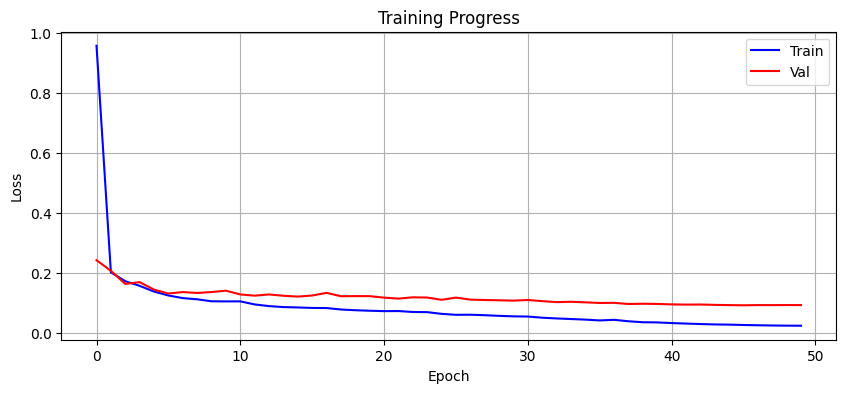

Best Val Loss: 0.0925 @ Epoch 46


In [19]:
# ============================================================================
# CELL 8: Plot Training Curves
# ============================================================================

history_path = Path(config['output_dir']) / 'history.json'
if history_path.exists():
    with open(history_path) as f:
        history = json.load(f)
    
    plt.figure(figsize=(10, 4))
    plt.plot(history['train'], 'b-', label='Train')
    plt.plot(history['val'], 'r-', label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Progress')
    plt.legend(); plt.grid(True)
    plt.savefig(Path(config['output_dir']) / 'loss_curve.png', dpi=150)
    plt.show()
    print(f"Best Val Loss: {min(history['val']):.4f} @ Epoch {history['val'].index(min(history['val']))+1}")
else:
    print("No training history found")

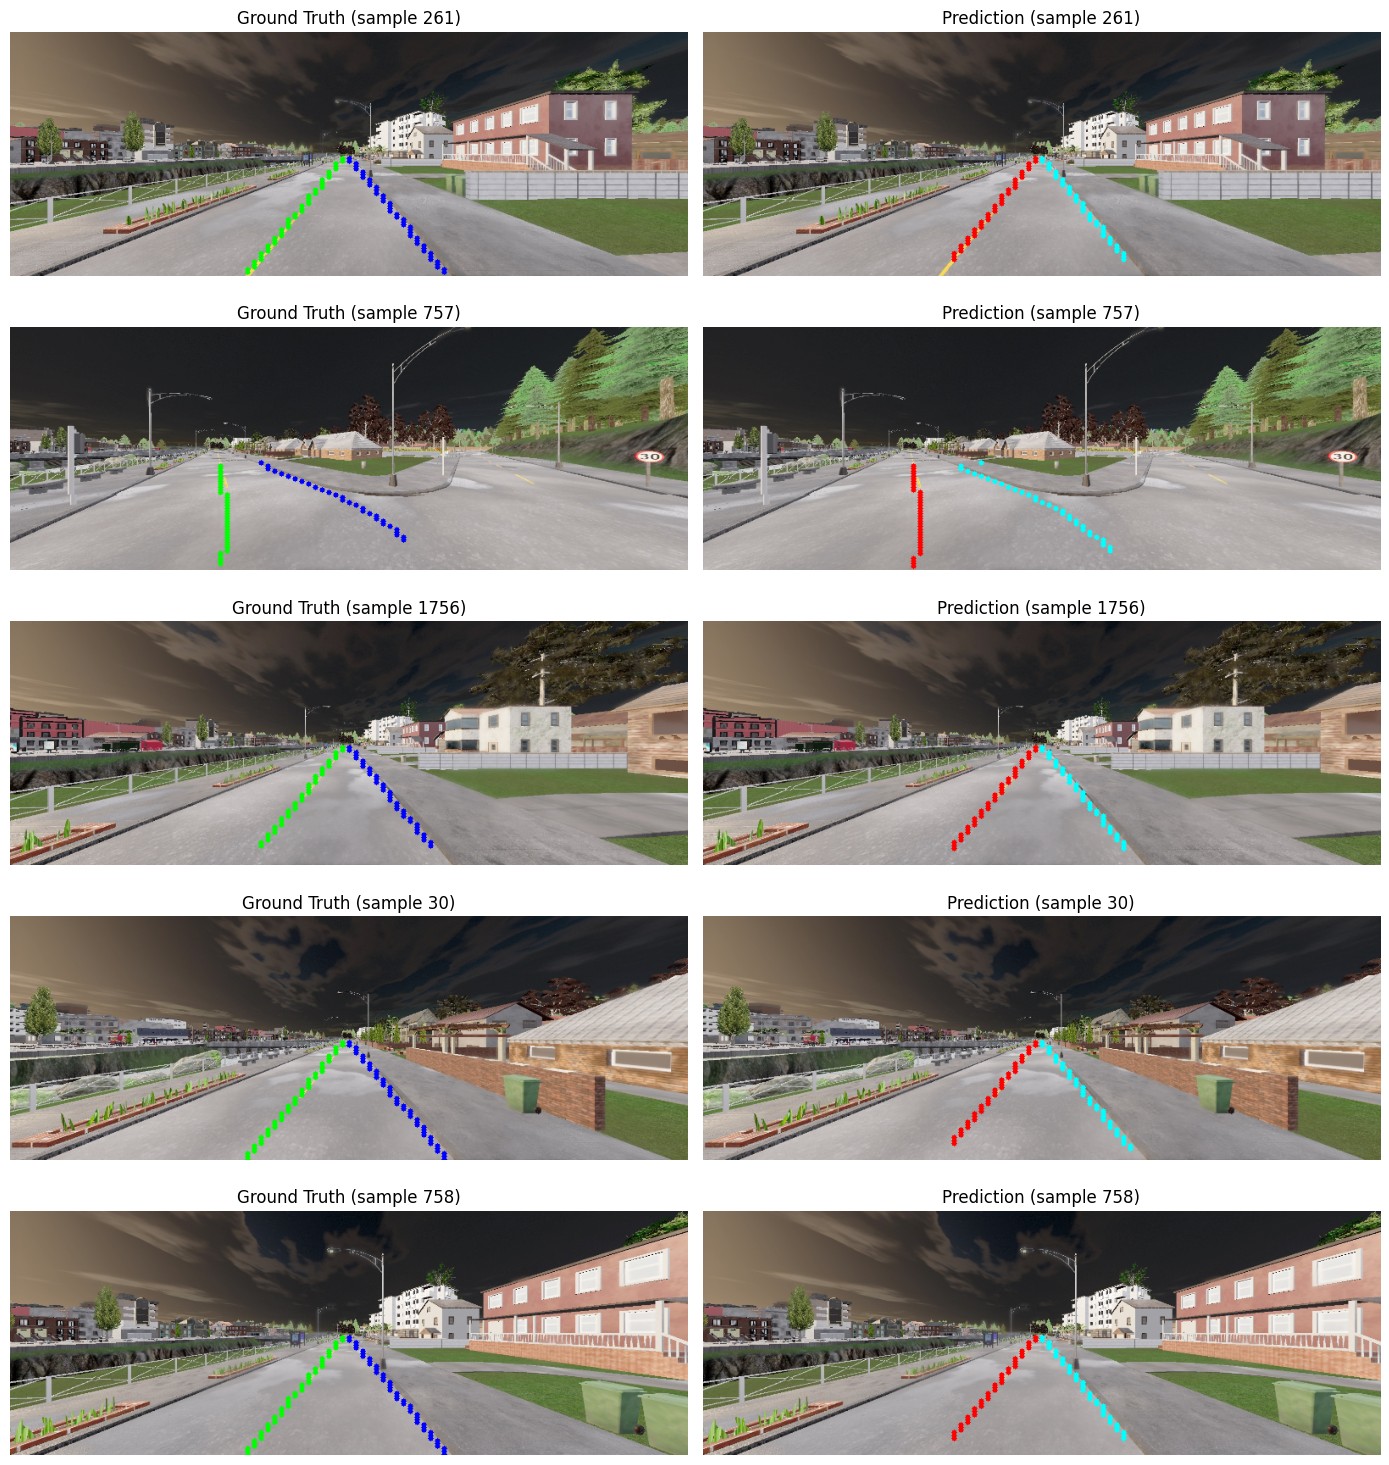

In [20]:
# ============================================================================
# CELL 9: Visualize Predictions
# ============================================================================

def visualize_predictions(model_path, dataset, n=5):
    """Test model and show predictions vs ground truth."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    ckpt = torch.load(model_path, map_location='cpu', weights_only=False)
    model = parsingNet(size=(config['img_h'], config['img_w']), pretrained=False, backbone=config['backbone'],
                       cls_dim=(config['griding_num']+1, config['cls_num_per_lane'], 4), use_aux=False)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval().to(device)
    
    row_anchors = np.linspace(int(config['img_h']*0.4), config['img_h']-1, config['cls_num_per_lane']).astype(int)
    fig, axes = plt.subplots(n, 2, figsize=(14, 3*n))
    
    for i in range(n):
        idx = np.random.randint(len(dataset))
        img, gt, _ = dataset[idx]
        
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).squeeze().cpu().numpy()
        
        # Denormalize
        vis = np.clip(img.permute(1,2,0).numpy() * [0.229,0.224,0.225] + [0.485,0.456,0.406], 0, 1)
        
        for ax_idx, (data, title, colors) in enumerate([
            (gt.numpy(), 'Ground Truth', [(0,1,0), (0,0,1)]),
            (pred, 'Prediction', [(1,0,0), (0,1,1)])
        ]):
            img_copy = vis.copy()
            for lane in range(2):
                for row_idx, y in enumerate(row_anchors):
                    x_grid = int(data[lane, row_idx]) if ax_idx == 0 else np.argmax(data[:, row_idx, lane])
                    if x_grid < config['griding_num']:
                        x = int(x_grid * config['img_w'] / config['griding_num'])
                        cv2.circle(img_copy, (x, y), 3, colors[lane], -1)
            axes[i, ax_idx].imshow(img_copy)
            axes[i, ax_idx].set_title(f'{title} (sample {idx})')
            axes[i, ax_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(Path(config['output_dir']) / 'predictions.png', dpi=150)
    plt.show()

model_path = Path(config['output_dir']) / 'checkpoint_best.pth'
if model_path.exists():
    visualize_predictions(model_path, trainer.val_loader.dataset)
else:
    print("Train model first")

In [ ]:
# ============================================================================
# CELL 10: Save to Google Drive (Colab only)
# ============================================================================

# Uncomment below when running on Colab:
# from google.colab import drive
# import shutil
# 
# drive.mount('/content/drive')
# drive_dir = '/content/drive/MyDrive/UFLD_CARLA'
# os.makedirs(drive_dir, exist_ok=True)
# shutil.copy(f"{config['output_dir']}/checkpoint_best.pth", f"{drive_dir}/ufld_carla_best.pth")
# shutil.copy(f"{config['output_dir']}/history.json", f"{drive_dir}/history.json")
# print(f"✅ Saved to {drive_dir}")

print("💡 Uncomment code above to save to Google Drive on Colab")